# Variable Density Tesseroids tests: Exponential Density

** Import Packages **

In [1]:
from __future__ import division
import numpy as np
from tesseroid_density import tesseroid
from fatiando.constants import G, MEAN_EARTH_RADIUS, SI2MGAL, SI2EOTVOS
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib.pyplot as plt

** Configuration for Pyplot Figures **

In [2]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 9.0 # fontsize of the x any y labels
plt.rcParams['xtick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 9.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True # use latex for all text handling
plt.rcParams['text.color'] = '3a3a3a'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = '3a3a3a'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

## Determination of D for exponential density

Now we are going to perform the same tests, but now with an exponential density:

\begin{equation}
\rho(r') = Ae^{-(r'-R)/b} + C
\end{equation}

The analytical solution of the potential generated by a spherical shell with this density function was obtained in the notebook called "02_spherical_shell_variable_density":

\begin{equation}
V_\text{exp}(r) = \frac{4\pi G Ab}{r} 
    e^\frac{\Delta h}{b}
    \left[
    (R_1^2 + 2R_1 b + 2b^2)e^{-\frac{R_1}{b}} -
    (R_2^2 + 2R_2 b + 2b^2)e^{-\frac{R_2}{b}}
    \right] + 
    \frac{4}{3}\pi GC
    \frac{R_2^3 - R_1^3}{r}
\end{equation}

We will perform this test for two cases: a thin shell (1km) and a thick shell (35km).

On both cases we propose that the density functions assumes a value of 2670kg/m$^3$ and 2900kg/m$^3$ at the outer and inner radii, respectively.

We won't apply the density-based discretization algorithm in order to isolate the modified adpative discretization algorithm behaviour.

### Thin Shell

** Definition of analytical solution for spherical shell **

In [3]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [4]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of exponential density function**

In [5]:
rho0, rho1 = 2670, 3300
b = 1e3
a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
c = rho0 - a
deltah = MEAN_EARTH_RADIUS

def density_exponential(height):
    r = height + MEAN_EARTH_RADIUS
    return a*np.exp(-(r - deltah)/b) + c

model.addprop("density", [density_exponential for i in range(model.size)])

**Determination of D for different grids**

In [6]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gxx gyy gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lats, lons, heights = grids[grid]
        analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D, delta=None)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/exponential-D/' + field + '-' + grid + '-thin-differences.npz',
                 D_values=D_values, diffs=diffs)

tesseroid_density/tesseroid.py:245: RuntimeWarning: Stopped dividing a tesseroid because it's dimensions would be below the minimum numerical threshold (1e-6 degrees or 1e-3 m). Will compute without division. Cannot guarantee the accuracy of the solution.
  warnings.warn(warning_msg, RuntimeWarning)


** Plot Results **

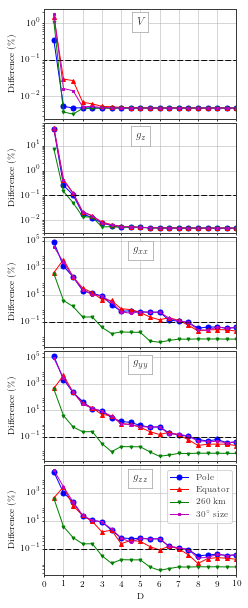

In [6]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gxx gyy gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = '$V$ $g_z$ $g_{xx}$ $g_{yy}$ $g_{zz}$'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 8.33))
fig.subplots_adjust(hspace=0)
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/exponential-D/' + field + '-' + 
                        grid + '-thin-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([-1, 11], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

### Thick Shell

** Definition of analytical solution for spherical shell **

In [7]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [8]:
top, bottom = 0, -35000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of exponential density function**

In [9]:
rho0, rho1 = 2670, 3300
b = 35e3
a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
c = rho0 - a
deltah = MEAN_EARTH_RADIUS

def density_exponential(height):
    r = height + MEAN_EARTH_RADIUS
    return a*np.exp(-(r - deltah)/b) + c

model.addprop("density", [density_exponential for i in range(model.size)])

**Determination of D for different grids**

In [11]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gxx gyy gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lats, lons, heights = grids[grid]
        analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D, delta=None)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/exponential-D/' + field + '-' + grid + '-thick-differences.npz',
                 D_values=D_values, diffs=diffs)

** Plot Results **

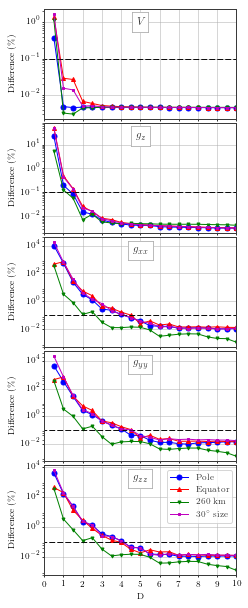

In [10]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gxx gyy gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = '$V$ $g_z$ $g_{xx}$ $g_{yy}$ $g_{zz}$'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 8.33))
fig.subplots_adjust(hspace=0)
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/exponential-D/' + field + '-' + 
                        grid + '-thick-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([-1, 11], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

## Accuracy vs the constant b in the power

Now we are going to calculate the $gzz$ component for different values of D and different values of the constant $b$ in the power of the density function in order to test how does the accuracy behaves when the exponential density gets steeper.

Again, we won't apply the density-based discretization algorithm.

### Thin Shell

** Definition of analytical solution for spherical shell **

In [11]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [12]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [13]:
shape = (10, 10)
lats, lons, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

**Determination of D for different constants b**

In [16]:
field = 'gzz'
b_values = [1e2, 5*1e2, 1e3, 1e4]
deltah = MEAN_EARTH_RADIUS
D_values = np.arange(0.5, 10.5, 0.5)
rho0, rho1 = 2670, 3300


for b in b_values:
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
    diffs = []
    model.addprop("density", [density_exponential for i in range(model.size)])
    for D in D_values:
        result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D, delta=None)
        diff = np.abs(result - analytical[field])/np.abs(analytical[field])
        diff = 100*np.max(diff)
        diffs.append(diff)
    diffs = np.array(diffs)
    np.savez('results/exponential-b/' + field + '-' +
             '{:.1e}'.format(b) + '-thin-differences.npz',
             D_values=D_values, diffs=diffs)

**Plot Results**

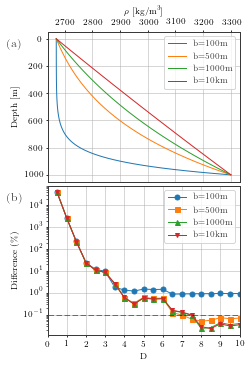

In [14]:
field = 'gzz'
b_values = [1e2, 5*1e2, 1e3, 1e4]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
markers = ["o", "s", "^", "v", "D"]
msize = [5, 5, 5, 4, 3]
labels = [r"b=100m", r"b=500m",
          r"b=1000m", r"b=10km"]
heights = np.linspace(bottom, top, 101)


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches((3.33, 5))

for b, m, ms, label in zip(b_values, markers, msize, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)
    
    diffs = np.load('results/exponential-b/' + field + '-' +
                    '{:.1e}'.format(b) + '-thin-differences.npz')
    D_values, diff = diffs['D_values'], diffs['diffs']
    ax2.plot(D_values, diff, '-', marker=m,
            markersize=ms, label=label)

ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(-0.21, 0.9, "(a)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax1.transAxes)

ax2.plot([0, 10], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
ax2.set_yscale('log')
ax2.set_yticks(ax2.get_yticks()[2:-2])
ax2.set_ylabel('Difference (\%)')
ax2.grid(True, linewidth=0.5, color='#aeaeae')
ax2.set_axisbelow(True)
ax2.set_xlabel(r"D")
ax2.set_xlim(0, 10)
ax2.set_xticks(np.arange(0, 11, 1))
ax2.legend(loc=1)
ax2.text(-0.21, 0.9, "(b)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax2.transAxes)

plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

### Thick Shell

** Definition of analytical solution for spherical shell **

In [15]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [16]:
top, bottom = 0, -35000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [17]:
shape = (10, 10)
lats, lons, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

**Determination of D for different constants b**

In [ ]:
field = 'gzz'
b_values = [10e3, 35e3, 100e3, 1000e3]
deltah = MEAN_EARTH_RADIUS
D_values = np.arange(0.5, 10.5, 0.5)
rho0, rho1 = 2670, 3300


for b in b_values:
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
    diffs = []
    model.addprop("density", [density_exponential for i in range(model.size)])
    for D in D_values:
        result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D, delta=None)
        diff = np.abs(result - analytical[field])/np.abs(analytical[field])
        diff = 100*np.max(diff)
        diffs.append(diff)
    diffs = np.array(diffs)
    np.savez('results/exponential-b/' + field + '-' +
             '{:.1e}'.format(b) + '-thick-differences.npz',
             D_values=D_values, diffs=diffs)

**Plot Results**

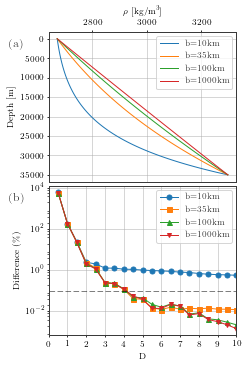

In [18]:
field = 'gzz'
b_values = [10e3, 35e3, 100e3, 1000e3]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
markers = ["o", "s", "^", "v", "D"]
msize = [5, 5, 5, 4, 3]
labels = [r"b=10km", r"b=35km",
          r"b=100km", r"b=1000km"]
heights = np.linspace(bottom, top, 101)


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches((3.33, 5))

for b, m, ms, label in zip(b_values, markers, msize, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)
    
    diffs = np.load('results/exponential-b/' + field + '-' +
                    '{:.1e}'.format(b) + '-thick-differences.npz')
    D_values, diff = diffs['D_values'], diffs['diffs']
    ax2.plot(D_values, diff, '-', marker=m,
            markersize=ms, label=label)

ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(-0.21, 0.9, "(a)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax1.transAxes)

ax2.plot([0, 10], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
ax2.set_yscale('log')
ax2.set_yticks(ax2.get_yticks()[2:-2])
ax2.set_ylabel('Difference (\%)')
ax2.grid(True, linewidth=0.5, color='#aeaeae')
ax2.set_axisbelow(True)
ax2.set_xlabel(r"D")
ax2.set_xlim(0, 10)
ax2.set_xticks(np.arange(0, 11, 1))
ax2.legend(loc=1)
ax2.text(-0.21, 0.9, "(b)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax2.transAxes)

plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

## Determination of delta

We are going to perform a test to determine the maximum value of delta needed to achieve a good accuracy.
In order to do this we are going to compute the differences between the numerical model and the analytical solution for several values of delta, and for different values of $b$.

We are going to plot one curve por each value of $b$ in a Difference vs delta graph.

### Thin Shell

** Definition of analytical solution for spherical shell **

In [3]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [4]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [5]:
shape = (10, 10)
lats, lons, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

** Compute the differences **

In [7]:
fields = 'potential gz gzz'.split()
b_values = [50, 100, 200, 300, 400]
deltah = MEAN_EARTH_RADIUS
delta_values = np.linspace(0.1, 1, 10)
rho0, rho1 = 2670, 3300

for field in fields:
    for b in b_values:
        # Define constant a in order to normalize the density function
        a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
        c = rho0 - a

        # Define new functions for each b
        def density_exponential(height):
            r = height + MEAN_EARTH_RADIUS
            return a*np.exp(-(r - deltah)/b) + c

        analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
        diffs = []
        model.addprop("density", [density_exponential for i in range(model.size)])
        for delta in delta_values:
            %time result = getattr(tesseroid, field)(lons, lats, heights, model, delta=delta)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)

        diffs = np.array(diffs)
        np.savez('results/exponential-delta/' + field + '-' +
                 '{:.1e}'.format(b) + '-thin-differences.npz',
                 deltas=delta_values, diffs=diffs)

CPU times: user 9.65 s, sys: 92 ms, total: 9.74 s
Wall time: 9.63 s
CPU times: user 5.18 s, sys: 92 ms, total: 5.27 s
Wall time: 5.15 s
CPU times: user 3.91 s, sys: 56 ms, total: 3.97 s
Wall time: 3.89 s
CPU times: user 2.44 s, sys: 84 ms, total: 2.53 s
Wall time: 2.41 s
CPU times: user 2.55 s, sys: 96 ms, total: 2.64 s
Wall time: 2.5 s
CPU times: user 2.52 s, sys: 68 ms, total: 2.58 s
Wall time: 2.48 s
CPU times: user 1.96 s, sys: 44 ms, total: 2.01 s
Wall time: 1.94 s
CPU times: user 1.05 s, sys: 52 ms, total: 1.1 s
Wall time: 997 ms
CPU times: user 496 ms, sys: 32 ms, total: 528 ms
Wall time: 477 ms
CPU times: user 548 ms, sys: 20 ms, total: 568 ms
Wall time: 517 ms
CPU times: user 8.49 s, sys: 52 ms, total: 8.54 s
Wall time: 8.47 s
CPU times: user 4.37 s, sys: 88 ms, total: 4.46 s
Wall time: 4.32 s
CPU times: user 2.56 s, sys: 64 ms, total: 2.63 s
Wall time: 2.49 s
CPU times: user 2.47 s, sys: 100 ms, total: 2.57 s
Wall time: 2.46 s
CPU times: user 1.98 s, sys: 56 ms, total: 2.04 s

tesseroid_density/tesseroid.py:240: RuntimeWarning: Stopped dividing a tesseroid because it's dimensions would be below the minimum numerical threshold (1e-6 degrees or 1e-3 m). Will compute without division. Cannot guarantee the accuracy of the solution.
  warnings.warn(warning_msg, RuntimeWarning)


CPU times: user 5min 54s, sys: 1.82 s, total: 5min 56s
Wall time: 5min 53s
CPU times: user 3min 23s, sys: 1.1 s, total: 3min 24s
Wall time: 3min 23s
CPU times: user 2min 28s, sys: 820 ms, total: 2min 29s
Wall time: 2min 28s
CPU times: user 1min 30s, sys: 672 ms, total: 1min 31s
Wall time: 1min 30s
CPU times: user 1min 31s, sys: 832 ms, total: 1min 32s
Wall time: 1min 31s
CPU times: user 1min 33s, sys: 800 ms, total: 1min 34s
Wall time: 1min 33s
CPU times: user 1min 16s, sys: 724 ms, total: 1min 17s
Wall time: 1min 16s
CPU times: user 36.9 s, sys: 364 ms, total: 37.2 s
Wall time: 36.7 s
CPU times: user 18.4 s, sys: 152 ms, total: 18.5 s
Wall time: 18.3 s
CPU times: user 18.6 s, sys: 152 ms, total: 18.7 s
Wall time: 18.5 s
CPU times: user 5min 50s, sys: 1.98 s, total: 5min 52s
Wall time: 5min 49s
CPU times: user 2min 55s, sys: 1 s, total: 2min 56s
Wall time: 2min 55s
CPU times: user 1min 34s, sys: 692 ms, total: 1min 34s
Wall time: 1min 33s
CPU times: user 1min 42s, sys: 648 ms, total: 1

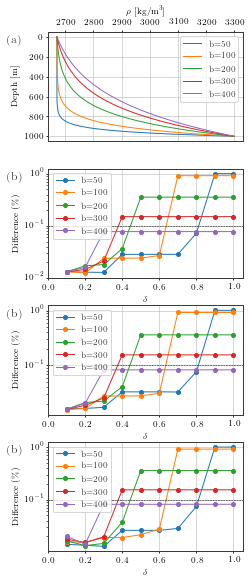

In [10]:
fields = 'potential gz gzz'.split()
b_values = [50, 100, 200, 300, 400]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
labels = ["b=" + str(b) for b in b_values]
heights = np.linspace(bottom, top, 101)

fig, axes = plt.subplots(4, 1)
fig.set_size_inches((3.33, 8))

ax1 = axes[0]

for b, label in zip(b_values, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)

for field, ax in zip(fields, axes[1:]):
    for b, label in zip(b_values, labels):  
        diffs = np.load('results/exponential-delta/' + field + '-' +
                        '{:.1e}'.format(b) + '-thin-differences.npz')
        deltas, diff = diffs['deltas'], diffs['diffs']
        ax.plot(deltas, diff, 'o-',
                markersize=4, label=label)


ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(-0.21, 0.9, "(a)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax1.transAxes)

for ax in axes[1:]:
    ax.plot([0, 1.2], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
    ax.set_xlim(0, 1.05)
    ax.set_yscale('log')
    ax.set_ylabel('Difference (\%)')
    ax.grid(True, linewidth=0.5, color='#aeaeae')
    ax.set_axisbelow(True)
    ax.set_xlabel(r"$\delta$")
    ax.legend()
    ax.text(-0.21, 0.9, "(b)", fontsize=12,
             fontdict={'weight': 'bold'},
             transform=ax.transAxes)
    
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

### Thick Shell

** Definition of analytical solution for spherical shell **

In [11]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [12]:
top, bottom = 0, -35000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [13]:
shape = (10, 10)
lats, lons, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

** Compute the differences **

In [14]:
#fields = 'potential gz gzz'.split()
fields = 'potential gz'.split()
b_values = [5000, 7500, 10000, 15000, 20000, 25000]
deltah = MEAN_EARTH_RADIUS
delta_values = np.linspace(0.1, 1, 10)
rho0, rho1 = 2670, 3300

for field in fields:
    for b in b_values:
        # Define constant a in order to normalize the density function
        a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
        c = rho0 - a

        # Define new functions for each b
        def density_exponential(height):
            r = height + MEAN_EARTH_RADIUS
            return a*np.exp(-(r - deltah)/b) + c

        analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
        diffs = []
        model.addprop("density", [density_exponential for i in range(model.size)])
        for delta in delta_values:
            %time result = getattr(tesseroid, field)(lons, lats, heights, model, delta=delta)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)

        diffs = np.array(diffs)
        np.savez('results/exponential-delta/' + field + '-' +
                 '{:.1e}'.format(b) + '-thick-differences.npz',
                 deltas=delta_values, diffs=diffs)

CPU times: user 5.72 s, sys: 56 ms, total: 5.77 s
Wall time: 5.68 s
CPU times: user 2.68 s, sys: 72 ms, total: 2.76 s
Wall time: 2.65 s
CPU times: user 1.91 s, sys: 120 ms, total: 2.03 s
Wall time: 1.85 s
CPU times: user 1.5 s, sys: 64 ms, total: 1.56 s
Wall time: 1.48 s
CPU times: user 1.19 s, sys: 116 ms, total: 1.3 s
Wall time: 1.18 s
CPU times: user 640 ms, sys: 60 ms, total: 700 ms
Wall time: 630 ms
CPU times: user 624 ms, sys: 48 ms, total: 672 ms
Wall time: 608 ms
CPU times: user 532 ms, sys: 40 ms, total: 572 ms
Wall time: 521 ms
CPU times: user 604 ms, sys: 32 ms, total: 636 ms
Wall time: 580 ms
CPU times: user 668 ms, sys: 48 ms, total: 716 ms
Wall time: 651 ms
CPU times: user 4.12 s, sys: 84 ms, total: 4.21 s
Wall time: 4.09 s
CPU times: user 1.87 s, sys: 108 ms, total: 1.98 s
Wall time: 1.85 s
CPU times: user 1.6 s, sys: 164 ms, total: 1.76 s
Wall time: 1.61 s
CPU times: user 1.12 s, sys: 64 ms, total: 1.18 s
Wall time: 1.08 s
CPU times: user 688 ms, sys: 48 ms, total: 736 

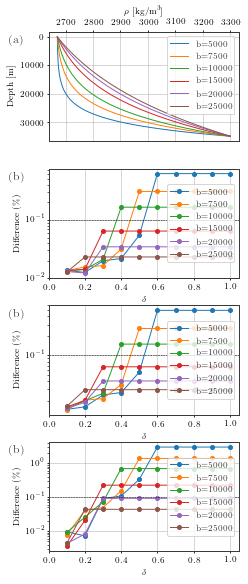

In [19]:
fields = 'potential gz gzz'.split()
b_values = [5000, 7500, 10000, 15000, 20000, 25000]
deltah = MEAN_EARTH_RADIUS
delta_values = np.linspace(0.1, 1, 10)
rho0, rho1 = 2670, 3300
labels = ["b=" + str(b) for b in b_values]
heights = np.linspace(bottom, top, 101)

fig, axes = plt.subplots(4, 1)
fig.set_size_inches((3.33, 8))

ax1 = axes[0]

for b, label in zip(b_values, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)

for field, ax in zip(fields, axes[1:]):
    for b, label in zip(b_values, labels):  
        diffs = np.load('results/exponential-delta/' + field + '-' +
                        '{:.1e}'.format(b) + '-thick-differences.npz')
        deltas, diff = diffs['deltas'], diffs['diffs']
        ax.plot(deltas, diff, 'o-',
                markersize=4, label=label)


ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(-0.21, 0.9, "(a)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax1.transAxes)

for ax in axes[1:]:
    ax.plot([0, 1.2], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
    ax.set_xlim(0, 1.05)
    ax.set_yscale('log')
    ax.set_ylabel('Difference (\%)')
    ax.grid(True, linewidth=0.5, color='#aeaeae')
    ax.set_axisbelow(True)
    ax.set_xlabel(r"$\delta$")
    ax.legend(loc=5)
    ax.text(-0.21, 0.9, "(b)", fontsize=12,
             fontdict={'weight': 'bold'},
             transform=ax.transAxes)
    
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()